# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [ ]:
"""
Data Set Information:

Data set has no missing values. 
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4. 
Each column represent one client. Some clients were created after 2011.In these cases consumption were considered zero. 
All time labels report to Portuguese hour. However all days present 96 measures (24*15). 
Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am 
are zero for all points. Every year in October time change day (which has 25 hours) 
the values between 1:00 am and 2:00 am aggregate the consumption of two hours. 

Attribute Information:

Data set were saved as txt using csv format, using semi colon (;). 
First column present date and time as a string with the following format 'yyyy-mm-dd hh:mm:ss' 
Other columns present float values with consumption in kW 

"""
import os
import zipfile
from six.moves import urllib
import pandas as pd
import fileinput

ZIP_NAME = "LD2011_2014.txt.zip"
DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/"
DATASET_PATH = os.path.join("datasets", "Electricity_Load")
DATASET_URL = DOWNLOAD_ROOT + ZIP_NAME
FILE_NAME = "LD2011_2014.txt"

In [ ]:
def Electricity_Data(DATASET_url=DATASET_URL, DATASET_path=DATASET_PATH):
    if not os.path.isdir(DATASET_path):
        os.makedirs(DATASET_path)
    file_path = os.path.join(DATASET_path,ZIP_NAME)
    
    urllib.request.urlretrieve(DATASET_URL, file_path) 
    # The commented code above wont execute in proxy settings. Please download the files from UCI
    # https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#
    Electric_zip = zipfile.ZipFile(file_path, 'r')
    Electric_zip.extractall(DATASET_path)  
    Electric_zip.close()

# Ran the code only once - Since the file is too large - The function call is commented out.
Electricity_Data()

In [ ]:
def load_Electricity_data(dataset_path=DATASET_PATH):
    file_path = os.path.join(dataset_path,FILE_NAME)
    with fileinput.FileInput(file_path, inplace=True, backup='.bak') as file:
        for line in file:
            print(line.replace(",", "."), end='')
    return pd.read_csv(file_path, sep=";", index_col=0)
    
data = load_Electricity_data()
#fileName = 'LD2011_2014.txt'

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

### Quick data inspection

In [ ]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,129.629630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,119.212963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,61.847988,161.702128,40.630182,48.500319,61.983471,78.018223,80.862534,335.463259,10.552764,64.317181,206.806283,34.246575,13.852243,45.267490,285.046729,35.593220,39.585871,128.007700,75.767063,60.984570,143.092105,33.994334,60.934891,31.424581,184.247539,10.327022,152.804642,113.874346,50.983248,52.197802,...,74.074074,54.132712,54.639175,15.440041,32.324269,62.992126,132.909483,121.212121,1747.967480,41.025641,638.539043,72.819034,32.515337,49.826188,971.014493,189.655172,0.0,40.69176,108.651911,174.129353,640.000000,23.255814,157.152021,26.052104,272.450533,16.472868,621.212121,214.513557,28.490028,190.789474,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,67.809240,163.829787,36.484245,46.585833,61.466942,73.462415,75.471698,319.488818,11.055276,67.841410,185.863874,31.133250,13.192612,45.953361,285.046729,39.830508,38.976857,128.970164,74.514715,58.045555,134.868421,29.272899,60.100167,30.027933,195.499297,8.605852,152.804642,112.565445,52.439913,46.703297,...,72.916667,52.968568,51.030928,14.925373,32.837352,63.976378,129.665948,121.212121,1738.211382,39.560440,555.415617,72.819034,31.901840,49.246813,946.859903,197.768763,0.0,0.00000,108.651911,149.253731,622.222222,23.255814,159.717768,24.048096,267.884323,16.472868,613.636364,217.703349,28.490028,175.438596,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [ ]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

### Plot the 2 days of 2012 for the first 2 clients

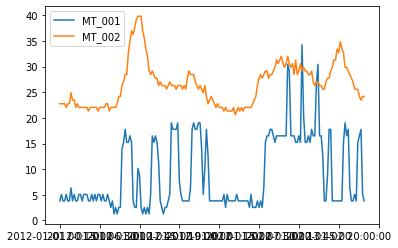

In [ ]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [ ]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [ ]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [ ]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [ ]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


In [ ]:
data_13_14.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,61.847988,0.0,38.142620,33.822591,0.0,39.293850,70.080863,341.853035,11.055276,57.268722,143.979058,31.13325,15.171504,32.235940,299.065421,27.118644,25.578563,93.358999,67.000626,0.0,115.131579,50.047214,50.918197,26.536313,135.021097,17.211704,119.922631,99.476440,0.0,175.824176,...,136.985294,44.45625,175.925926,2.910361,43.298969,19.042717,29.758851,90.551181,86.580087,1583.739837,34.432234,348.866499,75.702956,31.288344,67.786790,932.367150,125.760649,0.00000,91.549296,174.129353,653.333333,45.011253,192.431046,20.04008,389.649924,19.379845,734.848485,405.103668,35.612536,174.342105,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,64.828614,0.0,43.946932,35.737077,0.0,38.724374,72.776280,335.463259,9.547739,52.863436,151.832461,28.64259,13.192612,34.979424,294.392523,24.576271,24.360536,91.434071,63.869756,0.0,118.421053,47.214353,52.587646,26.536313,135.021097,15.490534,127.659574,102.094241,0.0,173.076923,...,131.102941,43.83125,157.407407,2.910361,43.298969,18.013381,29.245767,92.519685,90.909091,1536.585366,32.967033,342.569270,75.702956,31.288344,71.263036,917.874396,121.703854,40.69176,70.925553,149.253731,653.333333,45.761440,191.148172,20.04008,340.943683,19.379845,742.424242,385.964912,35.612536,164.473684,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486


## Getting average curves per client

In [ ]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [ ]:
#Map values using input correspondence (a dict, Series, or function)
data['hour'] = data.index.map(lambda x: x[11:])

In [ ]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,61.847988,0.0,38.142620,33.822591,0.0,39.293850,70.080863,341.853035,11.055276,57.268722,143.979058,31.13325,15.171504,32.235940,299.065421,27.118644,25.578563,93.358999,67.000626,0.0,115.131579,50.047214,50.918197,26.536313,135.021097,17.211704,119.922631,99.476440,0.0,175.824176,...,44.45625,175.925926,2.910361,43.298969,19.042717,29.758851,90.551181,86.580087,1583.739837,34.432234,348.866499,75.702956,31.288344,67.786790,932.367150,125.760649,0.00000,91.549296,174.129353,653.333333,45.011253,192.431046,20.04008,389.649924,19.379845,734.848485,405.103668,35.612536,174.342105,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,64.828614,0.0,43.946932,35.737077,0.0,38.724374,72.776280,335.463259,9.547739,52.863436,151.832461,28.64259,13.192612,34.979424,294.392523,24.576271,24.360536,91.434071,63.869756,0.0,118.421053,47.214353,52.587646,26.536313,135.021097,15.490534,127.659574,102.094241,0.0,173.076923,...,43.83125,157.407407,2.910361,43.298969,18.013381,29.245767,92.519685,90.909091,1536.585366,32.967033,342.569270,75.702956,31.288344,71.263036,917.874396,121.703854,40.69176,70.925553,149.253731,653.333333,45.761440,191.148172,20.04008,340.943683,19.379845,742.424242,385.964912,35.612536,164.473684,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00


### Getting average curves per client

In [ ]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [ ]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

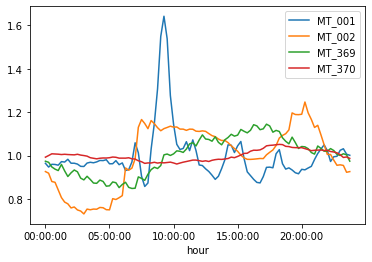

In [ ]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [ ]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format
X.shape

(349, 96)

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster 
      (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [ ]:
"""
Using the functions described in Module 2, 
determine what a convenient number of clusters based on intertia and based on silhouette. Justify your choice
"""

def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2  

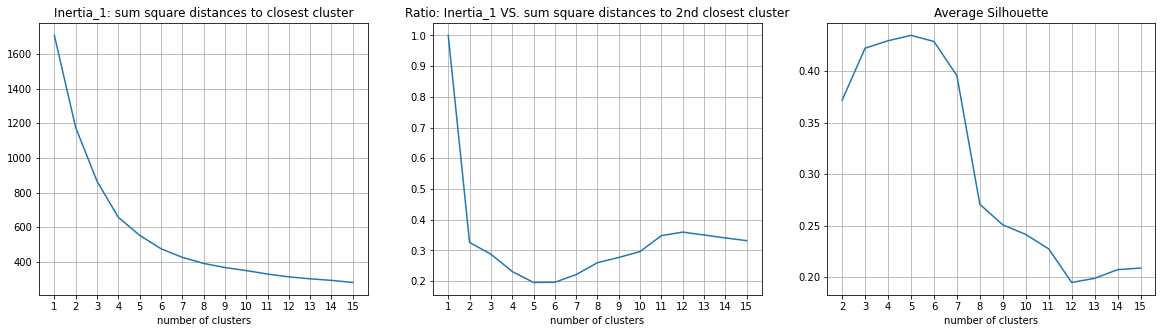

In [ ]:
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()   

Apply Kmeans Clustering

In [ ]:
trueK = 5

kmeans = KMeans(n_clusters=trueK, random_state=0).fit(X)

centroids = kmeans.cluster_centers_

centroids = centroids / np.mean(centroids) # Divide each centroid by its average

centroids.shape

(5, 96)

In [ ]:
kmeans_labels = kmeans.labels_ # Extract all the clusters for all 349 clients

Label_DF = pd.DataFrame(kmeans_labels)

keys = [i for i in range(kmeans_labels.shape[0])] #Create a Client identifier from 0 to 349 - clients

# Create a dictiory with keys between 0 and 348.

TR_Dictionary = dict(zip(keys, X))

# Create the Master Data Frame

Label_DF['Client'] = pd.Series(keys, index=Label_DF.index) # Merge the Clients and Cluster in the Data Frame

Label_DF.columns =['Cluster','Client']

Label_DF.groupby('Cluster')['Client'].count()

Sorted_Label_DF = Label_DF.sort_values(by=['Cluster'], ascending = True) # Sort all the clusters

In [ ]:
Label_DF_dataframe = pd.DataFrame(Label_DF)

In [ ]:
Label_DF_dataframe.shape

(349, 2)

In [ ]:
Label_DF_dataframe[Label_DF_dataframe['Cluster']==3] 

,Cluster,Client
92,3,92


In [ ]:
Label_DF_dataframe_subset = data.iloc[92]

In [ ]:
Label_DF_dataframe_subset

MT_001     2.53807
MT_002     24.1821
MT_003     3.47524
MT_004     162.602
MT_005     69.5122
            ...   
MT_367      530.29
MT_368     65.1085
MT_369      724.34
MT_370     6659.46
hour      23:15:00
Name: 2013-01-01 23:15:00, Length: 350, dtype: object

In [ ]:
# Filter all the dataframes and assign them the target matrices

Target_0 = Label_DF[Label_DF.Cluster == 0]
Target_Mat_0 = Target_0['Client'].to_numpy ()

Target_X_0 = [TR_Dictionary[i] for i in Target_Mat_0] #Map the dictionary to the Targets
Target_X_0 = np.array(Target_X_0)

Target_1 = Label_DF[Label_DF.Cluster == 1]
Target_Mat_1 = Target_1['Client'].to_numpy ()

Target_X_1 = [TR_Dictionary[i] for i in Target_Mat_1] #Map the dictionary to the Targets
Target_X_1 = np.array(Target_X_1)

Target_2 = Label_DF[Label_DF.Cluster == 2]
Target_Mat_2 = Target_2['Client'].to_numpy ()

Target_X_2 = [TR_Dictionary[i] for i in Target_Mat_2] #Map the dictionary to the Targets
Target_X_2 = np.array(Target_X_2)

Target_3 = Label_DF[Label_DF.Cluster == 3]
Target_Mat_3 = Target_3['Client'].to_numpy ()

Target_X_3 = [TR_Dictionary[i] for i in Target_Mat_3] #Map the dictionary to the Targets
Target_X_3 = np.array(Target_X_3)

Target_4 = Label_DF[Label_DF.Cluster == 4]
Target_Mat_4 = Target_4['Client'].to_numpy ()
Target_X_4 = [TR_Dictionary[i] for i in Target_Mat_4] #Map the dictionary to the Targets
Target_X_4 = np.array(Target_X_4)

Target_5 = Label_DF[Label_DF.Cluster == 5]
Target_Mat_5 = Target_5['Client'].to_numpy ()

Target_X_5 = [TR_Dictionary[i] for i in Target_Mat_5] #Map the dictionary to the Targets
Target_X_5 = np.array(Target_X_5)

In [ ]:
print(Target_0.shape)
print(Target_1.shape)
print(Target_2.shape)
print(Target_3.shape)
print(Target_4.shape)

(201, 2)
(109, 2)
(34, 2)
(1, 2)
(4, 2)


In [ ]:
#####APPLY COSMETICS FORMATTING FOR THE GRAPHS###########

import datetime

now = datetime.datetime(2013, 2, 9, 0, 00)
end=now+datetime.timedelta(hours=23.75)

l=[]
while now<=end:
    l.append(now)
    now+=datetime.timedelta(minutes=15)

x_axis_time = [t.strftime("%H:%M") for t in l]
x_axis_time = np.array(x_axis_time)
x_axis_time = x_axis_time.reshape([-1, 1])

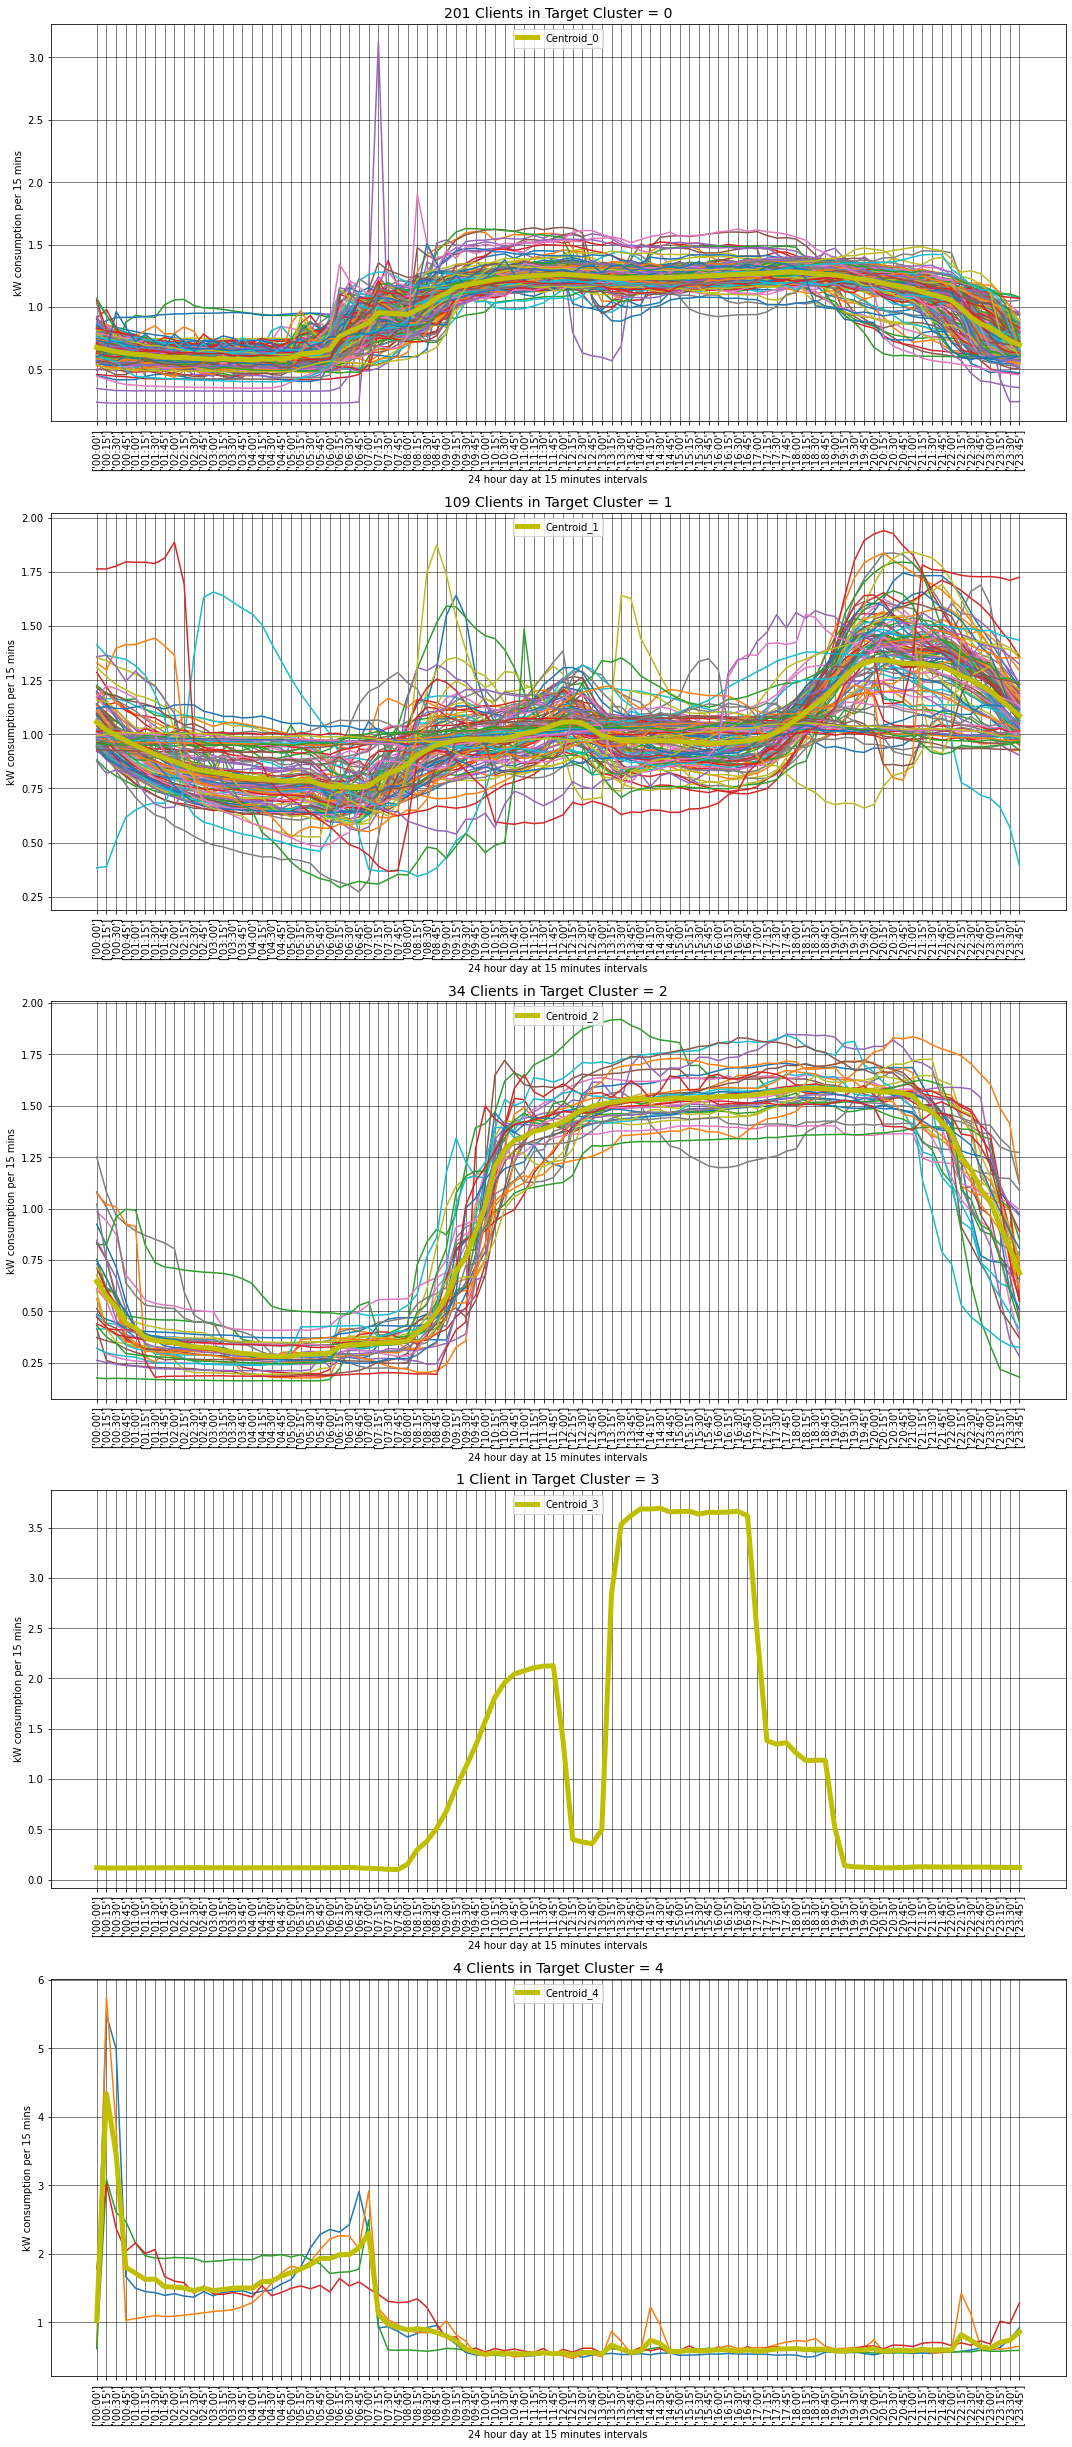

In [ ]:
# Time to graph

# plt.figure(figsize=(100,4))
plt.figure(figsize=(15,40))

x_axis = [i for i in range(96)]

plt.plot()

plt.subplot(6,1,1)
#plt.subplot(161)
plt.title("201 Clients in Target Cluster = 0", fontsize=14)
for i in range(Target_X_0.shape[0]):
    plt.plot(Target_X_0[i])
plt.plot(centroids[0], linewidth = 5, c = 'y', label = "Centroid_0")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical') # DO NOT DELETE
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,2)
#plt.subplot(162)
plt.title("109 Clients in Target Cluster = 1", fontsize=14)
for i in range(Target_X_1.shape[0]):
    plt.plot(Target_X_1[i])
plt.plot(centroids[1], linewidth = 5, c = 'y', label = "Centroid_1")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,3)
#plt.subplot(163)
plt.title("34 Clients in Target Cluster = 2", fontsize=14)
for i in range(Target_X_2.shape[0]):
    plt.plot(Target_X_2[i])
plt.plot(centroids[2], linewidth = 5, c = 'y', label = "Centroid_2")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,4)
#plt.subplot(164)
plt.title("1 Client in Target Cluster = 3", fontsize=14)
for i in range(Target_X_3.shape[0]):
    plt.plot(Target_X_3[i])
plt.plot(centroids[3], linewidth = 5, c = 'y', label = "Centroid_3")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,5)
#plt.subplot(165)
plt.title("4 Clients in Target Cluster = 4", fontsize=14)
for i in range(Target_X_4.shape[0]):
    plt.plot(Target_X_4[i])
plt.plot(centroids[4], linewidth = 5, c = 'y', label = "Centroid_4")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.show()

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [ ]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

X = X - np.mean(X, axis=0)/ np.std(X, axis=0)

In [ ]:
# 2.a Determine the optimal value for k-means ###

# Run inertia, inertia2, silhouette

def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

# Inertia 2

def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

# Computing 3 performance measures for a range of values of  k

inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

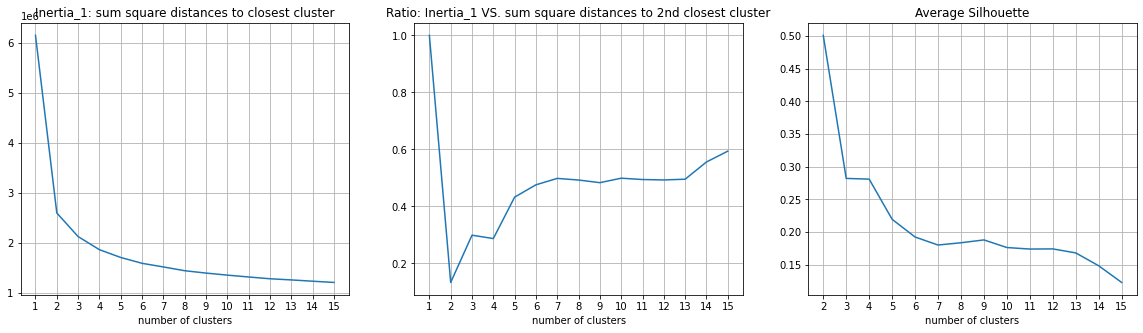

In [ ]:
# Plot the inertia, inertia2, silhouette

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

In [ ]:
K_true_new = 2

kmeans = KMeans(n_clusters=K_true_new, random_state=0).fit(X)

centroids = kmeans.cluster_centers_

#centroids = centroids / np.mean(centroids) # Divide each centroid by its average

centroids.shape

### b. What are the clusters that you obtained represent? ###

kmeans_labels = kmeans.labels_ 

Label_DF = pd.DataFrame(kmeans_labels)

keys = [i for i in range(kmeans_labels.shape[0])] #Create the key identifier between 0 and 729

# Create a dictionary with keys

TR_Dictionary = dict(zip(keys, X)) 

Label_DF['Data'] = pd.Series(keys, index=Label_DF.index) # Merge the actual data and Cluster in the Data Frame

Label_DF.columns =['Cluster','Data']

Label_DF.groupby('Cluster')['Data'].count()

Sorted_Label_DF = Label_DF.sort_values(by=['Cluster'], ascending = True) # Sort all the clusters

In [ ]:
Target_0 = Label_DF[Label_DF.Cluster == 0]
Target_Mat_0 = Target_0['Data'].to_numpy ()

Target_X_0 = [TR_Dictionary[i] for i in Target_Mat_0] #Map the dictionary to the Targets
Target_X_0 = np.array(Target_X_0)

Target_1 = Label_DF[Label_DF.Cluster == 1]
Target_Mat_1 = Target_1['Data'].to_numpy ()

Target_X_1 = [TR_Dictionary[i] for i in Target_Mat_1] #Map the dictionary to the Targets
Target_X_1 = np.array(Target_X_1)

In [ ]:
print(Target_0.shape)
print(Target_1.shape)

(219, 2)
(511, 2)


In [ ]:
#####APPLY COSMETICS FORMATTING FOR THE GRAPHS###########

import datetime

now = datetime.datetime(2013, 2, 9, 0, 00)
end=now+datetime.timedelta(hours=23.75)

l=[]
while now<=end:
    l.append(now)
    now+=datetime.timedelta(minutes=15)

x_axis_time = [t.strftime("%H:%M") for t in l]
x_axis_time = np.array(x_axis_time)
x_axis_time = x_axis_time.reshape([-1, 1])

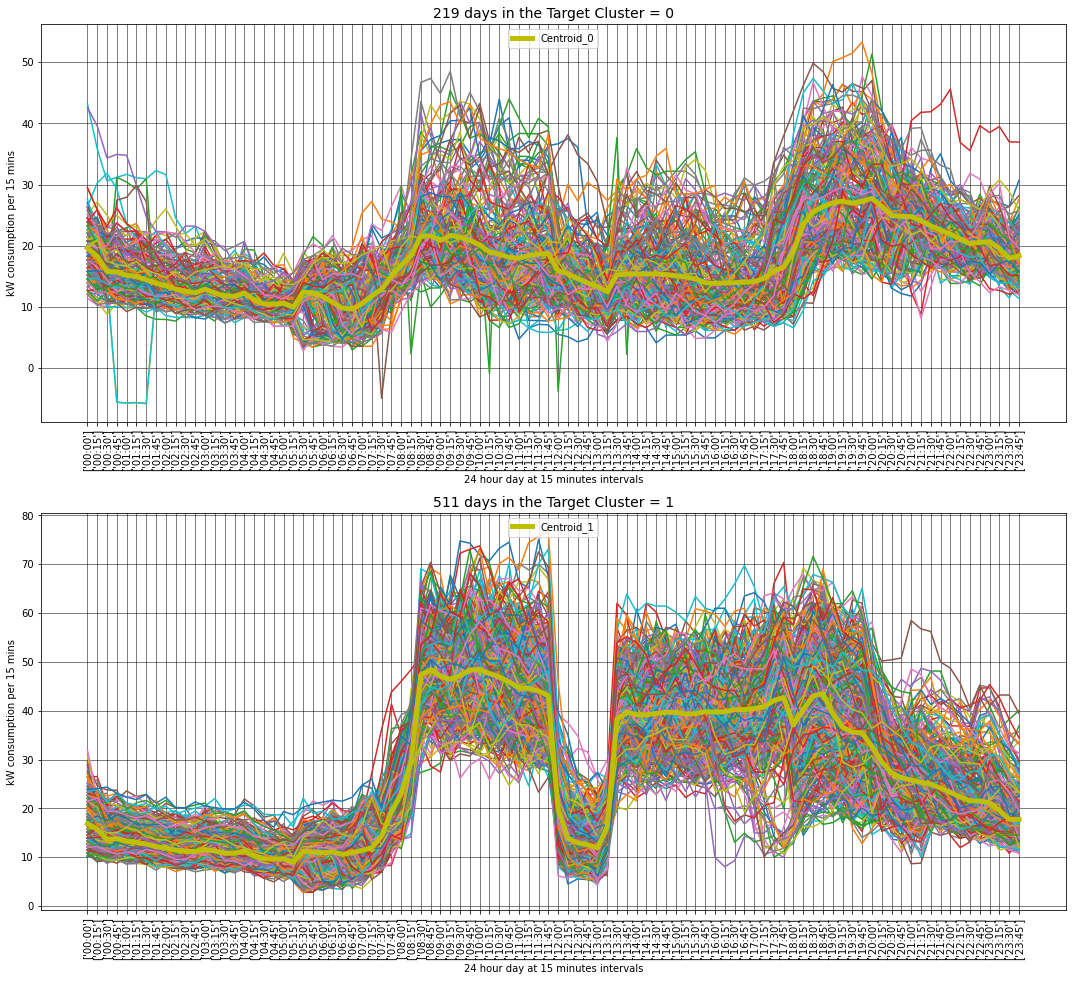

In [ ]:
# plt.figure(figsize=(100,4))
plt.figure(figsize=(15,40))

x_axis = [i for i in range(96)]

plt.plot()

plt.subplot(6,1,1)
#plt.subplot(161)
plt.title("219 days in the Target Cluster = 0", fontsize=14)
for i in range(Target_X_0.shape[0]):
    plt.plot(Target_X_0[i])
plt.plot(centroids[0], linewidth = 5, c = 'y', label = "Centroid_0")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical') # DO NOT DELETE
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,2)
#plt.subplot(162)
plt.title("511 days in the Target Cluster = 1", fontsize=14)
for i in range(Target_X_1.shape[0]):
    plt.plot(Target_X_1[i])
plt.plot(centroids[1], linewidth = 5, c = 'y', label = "Centroid_1")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.show()

#### Conclusion

Cluster 0 and Cluster 1 looks like the electricity usage during the workdays and statutory holidays and weekends. We can't have 219 days (Cluster 0) as weekends in a 2 years time frame, We have to factor the statutory holidays, which play a major in the usage pattern. 

For example. in Portugal, 25th April is the Freedom day. 25th April 2014 was a Friday - So any other Friday will have a different usage compared to this statutory holiday.   

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [ ]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [ ]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]